# 1. SETTINGS

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
import scipy.stats

from pandas.io.json import json_normalize
import json

import os
import time

In [174]:
# pandas options
pd.set_option("display.max_columns", None)

In [175]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [176]:
# garbage collection
import gc
gc.enable()

# 2. FUNCTIONS

In [177]:
##### FUNCTION 1: ENCODING FACTORS
def encode_factors(df, method = "label"):
    
    # label encoding
    if method == "label":
        factors = [f for f in df.columns if df[f].dtype == "object"]
        for var in factors:
            df[var], _ = pd.factorize(df[var])
        
    # dummy encoding
    if method == "dummy":
        df = pd.get_dummies(df, drop_first = True)
    
    # dataset
    return df

In [178]:
##### FUNCTION 2: AGGREGATIONS
def aggregate_data(df, group_var, num_stats = ['mean', 'sum'], 
                   label = None, sd_zeros = False):
    
    
    ### SEPARATE FEATURES
  
    # display info
    print("- Preparing the dataset...")

    # find factors
    df_factors = [f for f in df.columns if df[f].dtype == "object"]
    df_factors = ['fullVisitorId', 'device_operatingSystem', 'geoNetwork_country', 'channelGrouping']
        
    # partition subsets
    if type(group_var) == str:
        num_df = df[[group_var] + list(set(df.columns) - set(df_factors))]
        fac_df = df[df_factors]
    else:
        num_df = df[group_var + list(set(df.columns) - set(df_factors))]
        fac_df = df[df_factors]      
    
    # display info
    num_facs = fac_df.shape[1] - 1
    num_nums = num_df.shape[1] - 1
    print("- Extracted %.0f factors and %.0f numerics..." % (num_facs, num_nums))


    ##### AGGREGATION
 
    # aggregate numerics
    if (num_nums > 0):
        print("- Aggregating numeric features...")
        if type(group_var) == str:
            num_df = num_df.groupby([group_var]).agg(num_stats)
            num_df.columns = ["_".join(col).strip() for col in num_df.columns.values]
            num_df = num_df.sort_index()
        else:
            num_df = num_df.groupby(group_var).agg(num_stats)
            num_df.columns = ["_".join(col).strip() for col in num_df.columns.values]
            num_df = num_df.sort_index()

    # aggregate factors
    if (num_facs > 0):
        print("- Aggregating factor features...")
        if type(group_var) == str:
            fac_df = fac_df.groupby([group_var]).agg([("mode", lambda x: scipy.stats.mode(x)[0][0])])
            fac_df.columns = ["_".join(col).strip() for col in fac_df.columns.values]
            fac_df = fac_df.sort_index()
        else:
            fac_df = fac_df.groupby(group_var).agg([("mode", lambda x: scipy.stats.mode(x)[0][0])])
            fac_df.columns = ["_".join(col).strip() for col in fac_df.columns.values]
            fac_df = fac_df.sort_index()


    ##### MERGER

    # merge numerics and factors
    if ((num_facs > 0) & (num_nums > 0)):
        agg_df = pd.concat([num_df, fac_df], axis = 1)
    
    # use factors only
    if ((num_facs > 0) & (num_nums == 0)):
        agg_df = fac_df
        
    # use numerics only
    if ((num_facs == 0) & (num_nums > 0)):
        agg_df = num_df
        

    ##### LAST STEPS

    # update labels
    if (label != None):
        agg_df.columns = [label + "_" + str(col) for col in agg_df.columns]
    
    # impute zeros for SD
    if (sd_zeros == True):
        stdevs = agg_df.filter(like = "_std").columns
        for var in stdevs:
            agg_df[var].fillna(0, inplace = True)
            
    # dataset
    agg_df = agg_df.reset_index()
    print("- Final dimensions:", agg_df.shape)
    return agg_df

In [187]:
##### FUNCTION 3: ADD MONTH INDICATOR
def add_months_to_end(df, months = 12):

    df['months_to_end'] = np.nan

    for t in range(months):
        t_min = df.date.max() - pd.DateOffset(months = (t + 1))
        t_max = df.date.max() - pd.DateOffset(months = t)
        df.loc[(df.date > t_min) & (df.date <= t_max), 'months_to_end'] = t + 1
        
    #df['months_to_end'] = df['months_to_end'].astype('object')
        
    return df

In [188]:
##### FUNCTION 4: DATE FEATURES
def encode_date(df):
    
    attrs = [
             #'Year', 'Month', 'Week', 'Day', 
             'Dayofweek', 
             #'Dayofyear',
             #'Is_month_end', 'Is_month_start', 
             #'Is_quarter_end', 'Is_quarter_start', 
             #'Is_year_end', 'Is_year_start'
            ]
        
    for attr in attrs:
        df['date_' + attr] = getattr(df['date'].dt, attr.lower())
            
    return df

# 3. DATA PARTITIONING

In [189]:
# import CSV
df = pd.read_csv("../data/data_v1.csv.gz", compression = "gzip", dtype = {'fullVisitorId': 'str'})
print(df.shape)

(2109926, 40)


In [190]:
# check data
df.head()

,channelGrouping,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime,customDimensions_index,customDimensions_value
0,Organic Search,2017-10-16,Firefox,desktop,False,Windows,3162355547410993243,NaN,Europe,Germany,NaN,NaN,NaN,Western Europe,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,True,0,NaN,NaN,False,water bottle,organic,NaN,google,1508198450,1,1508198450,4,EMEA
1,Organic Search,2018-05-11,Chrome,mobile,True,Android,7460955084541987166,(not set),Asia,India,NaN,NaN,Delhi,Southern Asia,0,4,0,3,1,973,0,0,0,(not set),NaN,NaN,True,0,NaN,NaN,True,NaN,organic,(not set),google,1526099341,2,1526099341,4,EMEA
2,Referral,2017-10-16,Chrome,desktop,False,Chrome OS,8934116514970143966,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,NaN,California,Northern America,0,2,0,2,2,28,0,0,0,NaN,NaN,NaN,True,0,NaN,NaN,False,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,1508176307,6,1508176307,4,North America
3,Direct,2018-05-11,Chrome,desktop,False,Macintosh,460252456180441002,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,NaN,California,Northern America,0,4,0,3,1,49,0,0,0,(not set),NaN,NaN,True,0,NaN,NaN,True,NaN,(none),(not set),(direct),1526064483,166,1526064483,4,North America
4,Direct,2017-10-16,Chrome,mobile,True,Android,7992466427990357681,NaN,Americas,United States,NaN,windjammercable.net,NaN,Northern America,0,2,1,2,1,38,0,0,0,NaN,NaN,NaN,True,0,NaN,NaN,True,NaN,(none),NaN,(direct),1508201613,1,1508201613,4,North America


In [191]:
# convert dates
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)
print(df.date.min())
print(df.date.max())

2016-08-01 00:00:00
2018-10-15 00:00:00


In [192]:
# set windows
train_per = 168
valid_per = 62
valid_gap = 46

# number of folds
num_folds = 6

# placeholders
x_idx = []
y_idx = []

# partitioning loop
for i in range(num_folds):

    # validation dates
    if i == 0:
        v_end = df['date'].max() - pd.DateOffset(days = 15)
    else:
        v_end = df['date'].max() - pd.DateOffset(days = 15) - pd.DateOffset(months = i*2) + pd.DateOffset(days = 1)
    v_start = v_end - pd.DateOffset(days = valid_per - 1)

    # training dates
    t_end   = v_start - pd.DateOffset(days = valid_gap + 1)
    t_start = t_end - pd.DateOffset(days = train_per - 1)
    
    # extract index
    x_idx.append(list(df[(df.date >= t_start) & (df.date <= t_end)].index))
    y_idx.append(list(df[(df.date >= v_start) & (df.date <= v_end)].index))
    
    # print information
    print('------------------------------------------------')
    print("FOLD " + str(i + 1) + '/' + str(num_folds))
    print('------------------------------------------------')
    print('- features: ' + str(t_start)[0:10] + ' - ' + str(t_end)[0:10] + ' (n = ' + str(len(x_idx[i])) + ')')
    print('- targets:  ' + str(v_start)[0:10] + ' - ' + str(v_end)[0:10] + ' (n = ' + str(len(y_idx[i])) + ')')
    print('------------------------------------------------')
    print('')

------------------------------------------------
FOLD 1/6
------------------------------------------------
- features: 2017-12-29 - 2018-06-14 (n = 473345)
- targets:  2018-07-31 - 2018-09-30 (n = 137013)
------------------------------------------------

------------------------------------------------
FOLD 2/6
------------------------------------------------
- features: 2017-10-29 - 2018-04-14 (n = 498831)
- targets:  2018-05-31 - 2018-07-31 (n = 146339)
------------------------------------------------

------------------------------------------------
FOLD 3/6
------------------------------------------------
- features: 2017-08-29 - 2018-02-12 (n = 505741)
- targets:  2018-03-31 - 2018-05-31 (n = 171157)
------------------------------------------------

------------------------------------------------
FOLD 4/6
------------------------------------------------
- features: 2017-06-29 - 2017-12-13 (n = 494837)
- targets:  2018-01-29 - 2018-03-31 (n = 186193)
------------------------------

# 4. FEATURE ENGINEERING

In [195]:
### MAIN FUNCTION TO FEATURIZE THE DATA
def create_data(df, x_idx, y_idx, old_months = 6, agg_months = 1):

    ###### DATA PARTITIONING

    # extract X 
    x = df.iloc[x_idx]
    ids = x.fullVisitorId.unique()
    
    # append previous months to train
    old_x = x.date.min() - pd.DateOffset(months = old_months)
    old_x = df[(df.date >= old_x) & (df.date < x.date.min()) & (df.fullVisitorId.isin(ids))]
    x = pd.concat([x, old_x], axis = 0)
    
    # extract Y
    if len(y_idx) > 0:
        
        y = df.iloc[y_idx][['fullVisitorId', 'totals_transactionRevenue']]
        y['target'] = np.log1p(y.groupby('fullVisitorId').totals_transactionRevenue.transform('sum'))
        y = y[['fullVisitorId', 'target']]
        y.drop_duplicates(inplace = True)
        y = y.loc[y.fullVisitorId.isin(ids)]

        
    
    ###### FEATURE ENGINEERING
    
    ### AGGREGATIONS

    # aggregations (total)
    grp_x = aggregate_data(x, group_var = 'fullVisitorId')
    
    '''
    # aggregations (monthly)
    x = add_months_to_end(x, months = agg_months)
    for t in range(agg_months):
        tmp_x = x.loc[x.months_to_end <= (t + 1)]
        tmp_grp_x = aggregate_data(tmp_x, group_var = 'fullVisitorId', label = 'm' + str(t+1))
        grp_x     =  grp_x.merge(tmp_grp_x, how = 'left', on = 'fullVisitorId')      
    '''

    
    ### OTHER VARIABLES
    
    # correct visit number
    drops = list(grp_x.filter(like = 'visitNumber').columns)
    for var in drops:
        del grp_x[var]
    x['visit_max'] = x.groupby('fullVisitorId').visitNumber.transform('max')
    tmp = x[['fullVisitorId', 'visit_max']].drop_duplicates()
    grp_x = grp_x.merge(tmp, how = 'left', on = 'fullVisitorId')
    
    # add recency
    x['recency'] = x.groupby('fullVisitorId').date.transform('max')
    x['recency'] = ((x.date.max() - x['recency']) / np.timedelta64(1, 'D')).astype(int)
    tmp = x[['fullVisitorId', 'recency']].drop_duplicates()
    grp_x = grp_x.merge(tmp, how = 'left', on = 'fullVisitorId')

    # add frequency
    x['frequency'] = x.groupby('fullVisitorId').date.transform('count')
    tmp = x[['fullVisitorId', 'frequency']].drop_duplicates()
    grp_x = grp_x.merge(tmp, how = 'left', on = 'fullVisitorId')
    grp_x['frequency'].fillna(0, inplace = True)
    
    # day of the week
    #tmp = encode_date(x)
    #tmp = tmp[['fullVisitorId', 'date_Dayofweek']]
    #tmp = tmp.groupby('fullVisitorId').agg([("mode", lambda x: scipy.stats.mode(x)[0][0])])
    #tmp.columns = ["_".join(col).strip() for col in tmp.columns.values]
    #tmp = tmp.sort_index()
    #grp_x = grp_x.merge(tmp, how = 'left', on = 'fullVisitorId')
    
    
    ###### ALIGNMENT
    
    if len(y_idx) > 0:
    
        # merge zeros for new ids
        new_ids = list(set(grp_x.fullVisitorId) - set(y.fullVisitorId))
        new_ids = grp_x[grp_x.fullVisitorId.isin(new_ids)][['fullVisitorId']]
        y = y.merge(new_ids, how = 'outer', on = 'fullVisitorId')
        y.fillna(0, inplace = True)

        # align X and Y
        y = y.sort_values('fullVisitorId')['target'].reset_index(drop = True)
        x = grp_x.sort_values('fullVisitorId').reset_index(drop = True)
        return x, y
    
    else:
        
        x = grp_x.sort_values('fullVisitorId').reset_index(drop = True)
        return x

In [196]:
##### CONSTRUCT TEST DATA FIRST

# validation dates
v_end = pd.Timestamp('2019-01-31 00:00:00')
v_start = v_end - pd.DateOffset(days = valid_per - 1)

# training dates
t_end   = v_start - pd.DateOffset(days = valid_gap + 1)
t_start = t_end - pd.DateOffset(days = train_per - 1)

# extract index
xt_idx = list(df[(df.date >= t_start) & (df.date <= t_end)].index)
yt_idx = list(df[(df.date >= v_start) & (df.date <= v_end)].index)

# print information
print('------------------------------------------------')
print('- features: ' + str(t_start)[0:10] + ' - ' + str(t_end)[0:10] + ' (n = ' + str(len(xt_idx)) + ')')
print('- targets:  ' + str(v_start)[0:10] + ' - ' + str(v_end)[0:10] + ' (n = ' + str(len(yt_idx)) + ')')
print('------------------------------------------------')

# construct data
test_x = create_data(df, xt_idx, yt_idx)

------------------------------------------------
- features: 2018-05-01 - 2018-10-15 (n = 401589)
- targets:  2018-12-01 - 2019-01-31 (n = 0)
------------------------------------------------
- Preparing the dataset...
- Extracted 3 factors and 36 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (296530, 38)
- Preparing the dataset...
- Extracted 3 factors and 37 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (55309, 40)


# 5. MODELING

In [198]:
# drop bad features
excluded_feats = ['fullVisitorId', 'visitId', 'visitStartTime']

In [199]:
### PARAMETERS

# LGB parameters
lgb_params = {
    'boosting_type':   'gbdt',
    'objective':       'rmse',
    'metric':          'rmse',
    'subsample':        0.9,
    'feature_fraction': 0.7,
    'lambda_l1':        0.03,
    'lambda_l2':        0.03,
    'min_split_gain':   0.01,
    'min_child_weight': 5,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.03,
    'max_depth':        3,
    'n_estimators':     1000,
    'nthread' :         16
}

# loss function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [200]:
### CROSS-VALIDATION LOOP

# placeholders
clfs = []
oof_preds = []
oof_reals = []
test_preds = None
importances = pd.DataFrame()

# modeling loop
start  = time.time()
for i in range(5):
    
    # data partitioning
    print('------------------------------------------')
    val_x, val_y = create_data(df, x_idx[i],   y_idx[i])
    trn_x, trn_y = create_data(df, x_idx[i+1], y_idx[i+1])
    
    # drop bad features
    bad_feats = [list(trn_x.filter(like = f).columns) for f in excluded_feats]
    bad_feats = [item for sublist in bad_feats for item in sublist]
    features = [f for f in trn_x.columns if f not in bad_feats]
    trn_x = trn_x[features]
    val_x = val_x[features]
    tst_x = test_x[features]

    # label encoding   
    trn_x['trainid'] = 1
    val_x['trainid'] = 0
    tst_x['trainid'] = -1
    x = encode_factors(pd.concat([trn_x, val_x, tst_x], axis = 0), method = 'label')
    trn_x = x[x.trainid == 1]
    val_x = x[x.trainid == 0]
    tst_x = x[x.trainid == -1]
    del x, trn_x['trainid'], val_x['trainid'], tst_x['trainid']

    # train the model
    print('------------------------------------------')
    clf = lgb.LGBMRegressor(**lgb_params) 
    clf.fit(
        trn_x, trn_y,
        eval_set              = [(trn_x, trn_y), (val_x, val_y)],
        eval_metric           = 'rmse',
        verbose               = 50,
        early_stopping_rounds = 50,
    )
    clfs.append(clf)

    # OOF predictions
    oof_preds.append(list(clf.predict(val_x, num_iteration = clf.best_iteration_)))
    oof_reals.append(val_y)
    
    # TEST predictions
    cur_test_preds = clf.predict(tst_x[features], num_iteration = clf.best_iteration_)
    cur_test_preds = pd.Series(cur_test_preds)
    cur_test_preds[cur_test_preds < 0] = 0
    cur_test_preds = cur_test_preds.values
    if test_preds is None:
        test_preds =  cur_test_preds / 5
    else:
        test_preds += cur_test_preds / 5
    
    # feedback
    print('------------------------------------------')
    print('Fold ' + str(i + 1) + ': RMSE = ' + str(round(rmse(val_y, clf.predict(val_x, num_iteration = clf.best_iteration_)), 6)))  
    print('------------------------------------------')
    print('')

    # variable importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = i + 1
    importances = pd.concat([importances, imp_df], axis = 0, sort = False)
    
    # clean up
    gc.collect()
    
# OOF predictions
oof_preds = [item for sublist in oof_preds for item in sublist]
oof_reals = [item for sublist in oof_reals for item in sublist]
oof_preds_df = pd.DataFrame({'pred': oof_preds, 'real': oof_reals})
    
# print performance
cv_perf = rmse(oof_reals, oof_preds)
print('')
print('OOF RMSE: %.6f ' % cv_perf)
print('Done in %6.1f minutes' % ((time.time() - start) / 60))

------------------------------------------
- Preparing the dataset...
- Extracted 3 factors and 36 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (366163, 38)
- Preparing the dataset...
- Extracted 3 factors and 37 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (66060, 40)
- Preparing the dataset...
- Extracted 3 factors and 36 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (385330, 38)
- Preparing the dataset...
- Extracted 3 factors and 37 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (73450, 40)
------------------------------------------
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.145484	valid_1's rmse: 0.31656
[100]	training's rmse: 0.142521	valid_1's rmse: 0.315905
[150]	training's rmse: 0.140408	valid_1's rmse: 0.31563
[200]	training

In [201]:
###### TRACKING RESULTS

# numeric sums:           0.283247
# numeric means & sums:   0.283089
# correct visit number:   0.283058
# add modes for 3 facs:   0.283031

In [202]:
# calibration of porbs
preds = pd.Series(oof_preds)
preds[preds < 0] = 0
print('RMSE before: %.6f ' % rmse(oof_reals, oof_preds))
print('RMSE after:  %.6f ' % rmse(oof_reals, preds))

RMSE before: 0.283405 
RMSE after:  0.283397 


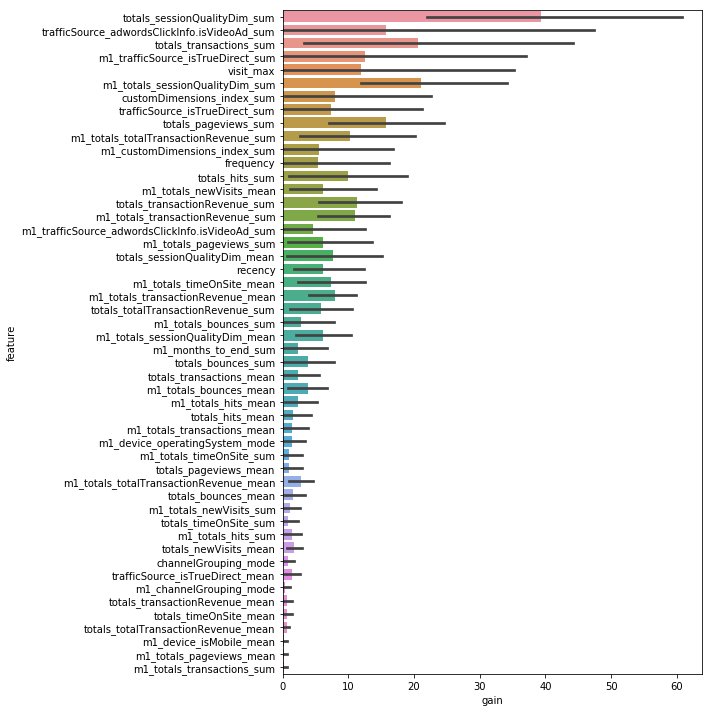

In [203]:
##### VARIABLE IMPORTANCE

# load importance 
top_feats = 50
cols = importances[["gain", "feature"]].groupby("feature").mean().sort_values(by = "gain", ascending = False)[0:top_feats].index
importance = importances.loc[importances.feature.isin(cols)]
importance = importance.sort_values(by = "gain", ascending = False)

# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "gain", y = "feature", data = importance)
plt.tight_layout()
plt.savefig('../var_importance.pdf')

# 5. SUBMISSION

In [204]:
# create submission
sub = pd.DataFrame(test_preds, columns = ['predictedLogRevenue'])
sub['fullVisitorId'] = test_x['fullVisitorId'].values
sub = sub[['fullVisitorId', 'predictedLogRevenue']]
print('Predictions shape: ', sub.shape)

Predictions shape:  (296530, 2)


In [205]:
# file name
model = 'lgb_v1'
perf  = str(round(cv_perf, 6))[2:8]
name  = model + '_' + perf

In [206]:
# export submission
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(296530, 2)

In [207]:
# export OOF preds
oof_preds_df.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof_preds_df.shape

(1855735, 2)